In [1]:
import sys
import numpy as np
import librosa

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import os

# import chainer
# from chainer import cuda, Variable, Chain, serializers
# import chainer.functions as F
# import chainer.links as L

# sys.path.append('../networks/')
from network import *

%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
logmel_Res = []
freqs = range(7995, 0, -10)
wav_len = int(16000 * 1.5)
fs = 16000

for freq in freqs:
    response = np.zeros([40])
    x = np.array([np.sin(2.0 * np.pi * freq * i / fs) for i in range(wav_len)])
#     print x, len(x)
    melspec = librosa.feature.melspectrogram(x, 16000, n_fft=800, hop_length=160, n_mels=40) # (40, 151)
#     print melspec, melspec.shape
    logmel = librosa.logamplitude(melspec) # (40, 151)
#     print 'logmel: ', logmel, logmel.shape
    res = np.mean(logmel[:, 10: 140], axis=1) # (40,)
#     print 'res: ', res, res.shape
    logmel_Res.append(res)
#     break
logmel_Res = np.array(logmel_Res) # (800, 40)
print logmel_Res
print logmel_Res.shape
mel_freq = 7995 - 10 * np.argmax(logmel_Res, axis=0)
print mel_freq

[[-76.07824083 -76.07824083 -76.07824083 ..., -76.07824083 -75.74303971
    0.73022487]
 [-75.22135952 -75.22135952 -75.22135952 ..., -75.22135952 -75.13812759
    4.392213  ]
 [-73.34366024 -73.34366024 -73.34366024 ..., -73.34366024 -73.34366024
    6.58963392]
 ..., 
 [ 24.42941279 -18.59132001 -37.74677493 ..., -55.50405065 -55.50405065
  -55.50405065]
 [ 22.23207991 -22.23446705 -38.35178193 ..., -57.38121605 -57.38121605
  -57.38121605]
 [ 18.56945269 -25.41218345 -40.00867502 ..., -58.23799887 -58.23799887
  -58.23799887]]
(800, 40)
[  75  145  225  295  365  445  515  585  665  735  805  885  955 1035 1115
 1205 1295 1395 1505 1625 1755 1895 2045 2205 2375 2565 2765 2985 3215 3475
 3745 4045 4365 4705 5075 5475 5905 6375 6875 7415]


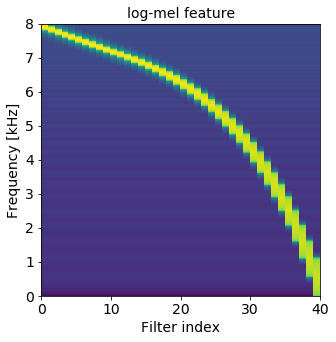

In [14]:
fig = plt.figure(figsize=(5, 5))

x, y = np.meshgrid(np.arange(41), np.arange(801) / 801. * 8) # (801, 41) (801, 41)
# print x.shape, y.shape
# print x
# print y
# plt.pcolor(x, y, np.flipud(logmel_Res)) # np.flipud 矩阵上下翻转
plt.pcolor(x, y, logmel_Res) # np.flipud 矩阵上下翻转
plt.title('log-mel feature', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

In [4]:
# Create sin waves

freqs = range(7995, 0, -10)
wav_len = int(44100 * 1.5)
fs = 44100
X = []

for freq in freqs:
    x = np.array([np.sin(2.0 * np.pi * freq * i / fs) for i in range(wav_len)])
    X.append(x[np.newaxis, :])
X = np.array(X).astype(np.float32) # (800, 1, fs*1.5)
# print X
print X.shape

(800, 1, 66150)


In [34]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

model = torch.load('../model/EnvNetMS_fold2_v2_epoch150.pkl')
model.cuda()

# print model
# Calculate pool2 of EnvNet
batchsize = 32
Res1 = []
Res2 = []
N = 800

Xt = torch.from_numpy(X)
Xt = Xt.cuda()
Xt = Variable(Xt)
for i in xrange(0, N, batchsize):
    print i
    x = Xt[i: i+batchsize]
    x1 = model.conv1_1(x)
    x1 = F.relu(model.bn1_1(x1))
    
    x2 = model.conv1_2(x)
    x2 = F.relu(model.bn1_2(x2))
    
    x1 = model.conv2_1(x1)
    x1 = F.relu(model.bn2_1(x1))
    
    x2 = model.conv2_2(x2)
    x2 = F.relu(model.bn2_2(x2))
    
    x1 = model.pool2_1(x1)
    x2 = model.pool2_2(x2)
  
    res1 = torch.mean(x1, dim=2)
    Res1.extend(res1.data.cpu().numpy())

    res2 = torch.mean(x2, dim=2)
    Res2.extend(res2.data.cpu().numpy())
# print Res
Res1 = np.asarray(Res1)
Res2 = np.asarray(Res2)

print Res1.shape
print Res2.shape

0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
(800, 40)
(800, 40)


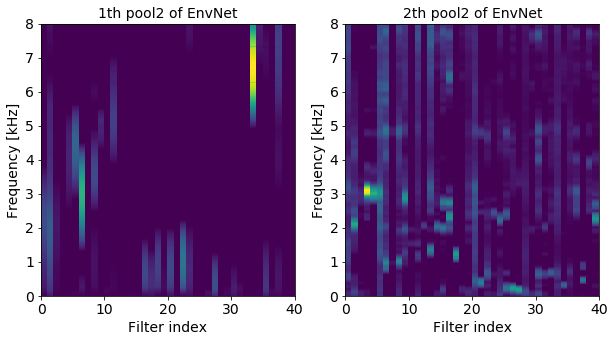

In [35]:
fig = plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
x, y = np.meshgrid(np.arange(41), np.arange(801) / 801. * 8)
plt.pcolor(x, y, np.flipud(Res1))
plt.title('1th pool2 of EnvNet', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

plt.subplot(1,2,2)
x, y = np.meshgrid(np.arange(41), np.arange(801) / 801. * 8)
plt.pcolor(x, y, np.flipud(Res2))
plt.title('2th pool2 of EnvNet', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

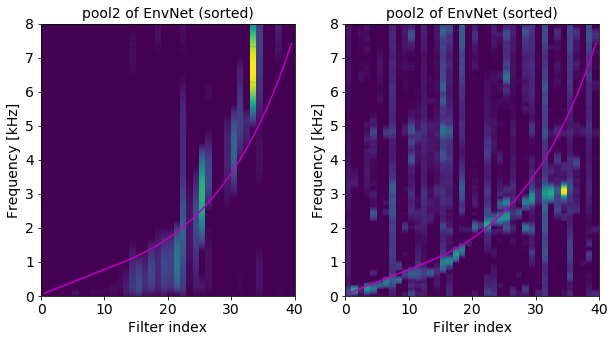

In [36]:
center_freq1 = 7995 - 10 * np.argmax(Res1, axis=0)
center_freq2 = 7995 - 10 * np.argmax(Res2, axis=0)
# rm_index = [5, 6, 7, 8, 18] # filters which respond to all frequency area are removed
# center_freq[rm_index] = 8000
sort_index1 = np.argsort(center_freq1)[:40]
sort_index2 = np.argsort(center_freq2)[:40]
sorted_Res1 = Res1[:, sort_index1]
sorted_Res2 = Res2[:, sort_index2]

fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
x, y = np.meshgrid(np.arange(41), np.arange(801) / 801. * 8)
plt.pcolor(x, y, np.flipud(sorted_Res1))
plt.plot(np.arange(40) * (40) / 40. + 0.5 , mel_freq / 1000., 'm')
plt.title('pool2 of EnvNet (sorted)', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

plt.subplot(1, 2, 2)
x, y = np.meshgrid(np.arange(41), np.arange(801) / 801. * 8)
plt.pcolor(x, y, np.flipud(sorted_Res2))
plt.plot(np.arange(40) * (40) / 40. + 0.5 , mel_freq / 1000., 'm')
plt.title('pool2 of EnvNet (sorted)', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

In [34]:
np.savetxt('../figures/txt/response.txt', Res)
np.savetxt('../figures/txt/sorted_response.txt', sorted_Res)
np.savetxt('../figures/txt/logmel_response.txt', logmel_Res)
np.savetxt('../figures/txt/mel_freq.txt', mel_freq)